In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import umap
import plotly.express as px
import plotly.graph_objects as go

import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from os.path import join as oj
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier



In [2]:
animal = 'RRM026'
session = 'Day176'
root_folder = '/Users/yang/Documents/Wilbrecht_Lab/data4analysis/cleaned_preprocessed_data'

'''
# following code block is used to extract assigned animal and session
animal_folder = oj(root_folder, animal)

dataframes = []

# Check if the animal folder exists
if os.path.isdir(animal_folder):
    session_folder = oj(animal_folder, session)
    if os.path.isdir(session_folder):
        for filename in os.listdir(session_folder):
            if filename.startswith(f'{animal}_{session}') and filename.endswith('_processed.csv'):
                file_path = oj(session_folder, filename)
                df = pd.read_csv(file_path, index_col=0)
                dataframes.append(df)
    else:
        print('No matching session folder found.')
else:
    print('No matching animal folder found.')

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    print("No matching files found.")
    '''


'\n# following code block is used to extract assigned animal and session\nanimal_folder = oj(root_folder, animal)\n\ndataframes = []\n\n# Check if the animal folder exists\nif os.path.isdir(animal_folder):\n    session_folder = oj(animal_folder, session)\n    if os.path.isdir(session_folder):\n        for filename in os.listdir(session_folder):\n            if filename.startswith(f\'{animal}_{session}\') and filename.endswith(\'_processed.csv\'):\n                file_path = oj(session_folder, filename)\n                df = pd.read_csv(file_path, index_col=0)\n                dataframes.append(df)\n    else:\n        print(\'No matching session folder found.\')\nelse:\n    print(\'No matching animal folder found.\')\n\nif dataframes:\n    combined_df = pd.concat(dataframes, ignore_index=True)\nelse:\n    print("No matching files found.")\n    '

In [3]:
combined_df = pd.read_csv(oj(root_folder, 'combined_df.csv'), index_col=0)

In [4]:
print(combined_df.shape)
combined_df.head()


(837305, 38)


Head x      Head y      Neck x      Neck y     Torso x     Torso y  \
index                                                                           
0       97.949959  125.948250   90.718018  125.915596   78.312035  126.051994   
1      103.294258  126.465607   98.100525  126.174385   85.752670  125.916733   
2      111.046303  126.946213  105.955849  126.559837   93.239532  126.049316   
3      118.300751  127.073494  111.140808  126.629097   98.491478  126.034889   
4      126.184807  126.752533  119.117012  126.511871  106.560745  126.113716   

       Tailhead x  Tailhead y  warped Head x  warped Head y  ...  \
index                                                        ...   
0       68.342316  123.691650     297.271604     125.932236  ...   
1       74.097397  125.736877     297.810956     119.994282  ...   
2       80.696983  125.685104     298.240149     113.552809  ...   
3       86.217712  123.775703     298.339819     106.815038  ...   
4       94.671455  125.946205     298.074981     100.134950  ...   

       Head velocity  Neck velocity  Torso velocity  Tailhead velocity  \
index                                                                    
0           0.000000       0.000000        0.000000           0.000000   
1         178.871955     203.448296      202.902146         165.884591   
2         193.672671     194.897766      191.070609         169.254464   
3         202.155225     184.029159      180.190742         180.965354   
4         200.560089     200.765801      204.062318         214.144352   

       Head acceleration  Neck acceleration  Torso acceleration  \
index                                                             
0            5366.158657        6103.448865         6087.064396   
1             444.021472        -256.515885         -354.946138   
2             254.476626        -326.058207         -326.396008   
3             -47.854098         502.099255          716.147302   
4            -242.376664         267.522220          322.237925   

       Tailhead acceleration  animal  session  
index                                          
0                4976.537731  RRM028   Day136  
1                 101.096186  RRM028   Day136  
2                 351.326716  RRM028   Day136  
3                 995.369931  RRM028   Day136  
4                 183.658880  RRM028   Day136  

[5 rows x 38 columns]

### over 92% trial length is greater than 37 frames (~1 second). also, most straight walking length is less than 30 frames. then we use the first 37 frames to cluster the trajectories.

In [15]:
current_trial_num = 1
current_decision = np.nan
current_restaurant = np.nan
decision = np.nan
current_length = 0
sum_of_speed = 0
speed_count = 0
coord_length = 37 # extract first 37 frames of coords of each trial

#bonsai_decision_list = []
decision_list = []
straight_walking_speed_list =[]
animal_list = []
session_list = []
trial_list = []
trial_lengths = []
current_trial_coords = []
trial_13_coords = []


for index, row in combined_df.iterrows():
    decision = row['decision']
    trial_num = row['trial']
    animal = row['animal']
    session = row['session']
    speed = row['Head velocity']
    restaurant = row['restaurant']
    head_x = row['warped Head x']
    head_y = row['warped Head y']

    if trial_num != current_trial_num: # Start of a new trial
        
        if speed_count != 0:
            average_speed = sum_of_speed/speed_count
        else:
            average_speed = np.nan
            
        if len(current_trial_coords) >= coord_length * 2:
            if average_speed > 150:
                trial_13_coords.append(current_trial_coords[:(coord_length * 2)])
                decision_list.append(current_decision)
                straight_walking_speed_list.append(average_speed)
                animal_list.append(animal)
                session_list.append(session)
                trial_list.append(current_trial_num)
                trial_lengths.append(current_length)

        current_restaurant = restaurant
        current_decision = np.nan
        current_trial_num = trial_num 
        sum_of_speed = 0
        speed_count = 0
        current_length = 1
        current_trial_coords = [head_x, head_y]

    else: # Within trial
        current_length += 1
        current_trial_coords.append(head_x)
        current_trial_coords.append(head_y)
        
    if not pd.isna(decision): # Decision != None
        current_decision = decision
    
    if pd.isna(current_decision) and (speed < 300): # Straight walking speed
        sum_of_speed += speed
        speed_count += 1

coord_columns = [f'x{i//2+1}' if i % 2 == 0 else f'y{i//2+1}' for i in range(coord_length * 2)]
coords_df = pd.DataFrame(trial_13_coords, columns=coord_columns)

other_df = pd.DataFrame({
    #'bonsai decision': bonsai_decision_list,
    'decision': decision_list,
    'straight_walking_speed': straight_walking_speed_list,
    'animal': animal_list,
    'session': session_list,
    'trial': trial_list,
    'trial_length': trial_lengths,
})

result_df = pd.concat([coords_df, other_df], axis=1)

In [16]:
result_df.head()

x1          y1          x2          y2          x3          y3  \
0  297.271604  125.932236  297.810956  119.994282  298.240149  113.552809   
1  289.563935  128.447126  290.005645  122.230493  290.581654  115.873554   
2  293.917806  126.046794  293.697025  121.348562  293.512995  116.439108   
3  286.956016  131.687361  288.450812  127.777012  289.553869  123.526205   
4  286.481579  129.104102  288.540240  125.478926  289.323751  121.775837   

           x4          y4          x5          y5  ...         x36        y36  \
0  298.339819  106.815038  298.074981  100.134950  ...  322.765489  24.574567   
1  291.508640  109.050360  292.761309  101.645353  ...  322.320363  39.690606   
2  293.405168  111.175115  293.394795  105.557408  ...  322.108516  40.074612   
3  290.203186  118.759048  290.553729  113.821701  ...  322.917161  39.612163   
4  289.905958  117.851038  291.111284  113.488322  ...  321.822602  43.067085   

          x37        y37  decision  straight_walking_speed  animal  session  \
0  323.862845  24.930622      quit              150.649940  RRM028   Day136   
1  322.019444  39.337858       ACC              229.864156  RRM028   Day136   
2  322.072555  40.277608       ACC              185.055303  RRM028   Day136   
3  323.027309  39.386006      quit              150.978190  RRM028   Day136   
4  321.852174  43.035500       ACC              164.766663  RRM028   Day136   

   trial  trial_length  
0      1           159  
1      5            46  
2      9            46  
3     13           169  
4     17            48  

[5 rows x 80 columns]

(array([988., 928., 781., 504., 333., 178.,  94.,  65.,  18.,  12.]),
 array([150.01109873, 163.65142555, 177.29175237, 190.9320792 ,
        204.57240602, 218.21273284, 231.85305966, 245.49338648,
        259.13371331, 272.77404013, 286.41436695]),
 <BarContainer object of 10 artists>)

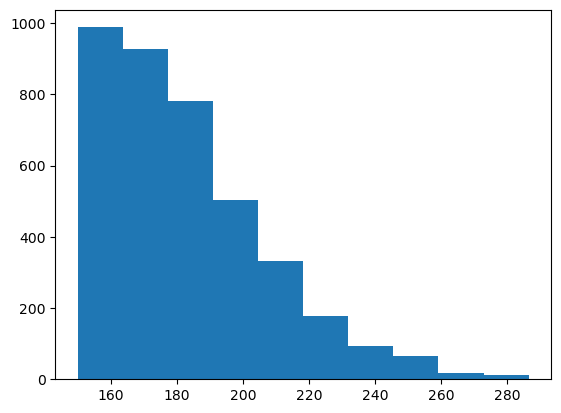

In [17]:
plt.hist(result_df['straight_walking_speed'])

In [18]:
# Define the histogram
fig = px.histogram(result_df, x='trial_length', color='decision',
                   title='Distribution of Trial Lengths by Decision',
                   labels={'trial_length': 'Number of Frames per Trial'},
                   nbins=2000,  # Set number of bins
                   opacity=0.5)  # Set opacity for overlapping

# Customize layout
fig.update_layout(
    xaxis_title='Number of Frames per Trial',
    yaxis_title='Frequency',
    bargap=0.1,
    legend_title='Decision',
    template='plotly_white',
)
fig.update_xaxes(range=[0, 2000])
# Show the figure
fig.show()


In [19]:
decision_palette_dict = {
    "ACC": (0, 1, 0),  # Green with transparency
    "REJ": (1, 0, 0),  # Red with transparency
    "quit": (0, 0, 1),  # Blue with transparency
    "T-Entry": (1, 1, 1), # black
    np.nan: (1, 1, 1) # black
}
fig = go.Figure()
for index, row in result_df[:5000].iterrows():
    x_coords = [row[f'x{i}'] for i in range(1, 38)]
    y_coords = [row[f'y{i}'] for i in range(1, 38)]
    # Extract animal, session, and trial information
    decision, animal, session, trial = row['decision'], row['animal'], row['session'], row['trial']
    # Determine the color for the current trial
    color = 'rgba' + str(tuple(int(c * 255) for c in decision_palette_dict[decision]) + (0.2,))
    fig.add_trace(go.Scatter(
        x=x_coords, y=y_coords,
        mode='lines',
        name=f'Trial {row["trial"]}',
        line=dict(color=color, width=0.5),
    ))

fig.update_layout(
    title='Coordinates of Each Trial',
    xaxis_title='X Coordinates',
    yaxis_title='Y Coordinates',
    yaxis=dict(autorange='reversed'),
    showlegend=False,
)

fig.show()

In [20]:
# Define the trajectory columns
umap_columns = [f'x{i}' for i in range(1, 38)] + [f'y{i}' for i in range(1, 38)]

# Extract the coordinate data
coords_data = result_df[umap_columns]

n_components = 5
n_clusters = 5

# Perform UMAP
reducer = umap.UMAP(n_components=n_components, random_state=42)
umap_components = reducer.fit_transform(coords_data)

# Create a DataFrame for the UMAP components
umap_columns = [f'UMAP{i+1}' for i in range(n_components)]
umap_df = pd.DataFrame(umap_components, columns=umap_columns)

# Add the UMAP components to the original DataFrame
coords_umap = pd.concat([result_df.reset_index(drop=True), umap_df.reset_index(drop=True)], axis=1)

# Scatter plot of UMAP1 and UMAP2 with decisions using Plotly
fig = px.scatter(coords_umap, x='UMAP1', y='UMAP2', color='decision',
                 title='Scatter Plot of UMAP1 and UMAP2 with Decision Distributions',
                 labels={'UMAP1': 'UMAP1', 'UMAP2': 'UMAP2'},
                 hover_data=['decision'])
fig.update_traces(marker=dict(size=2))
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



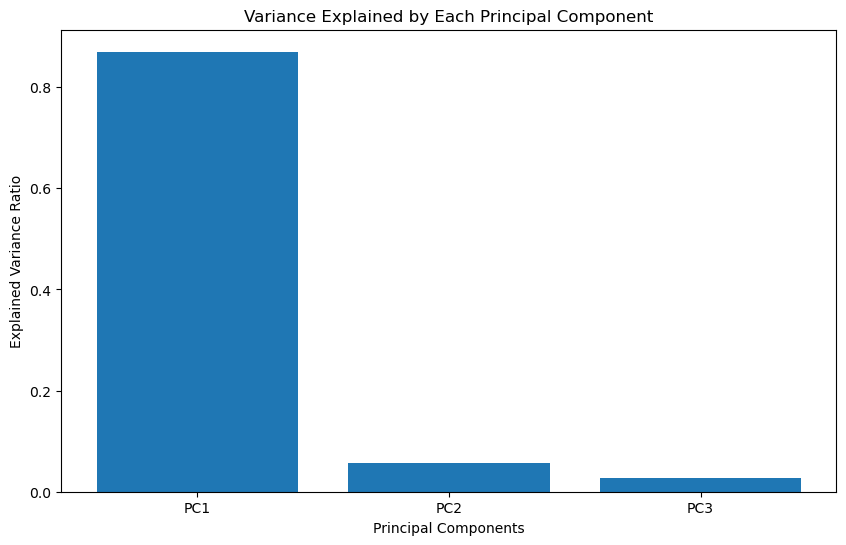

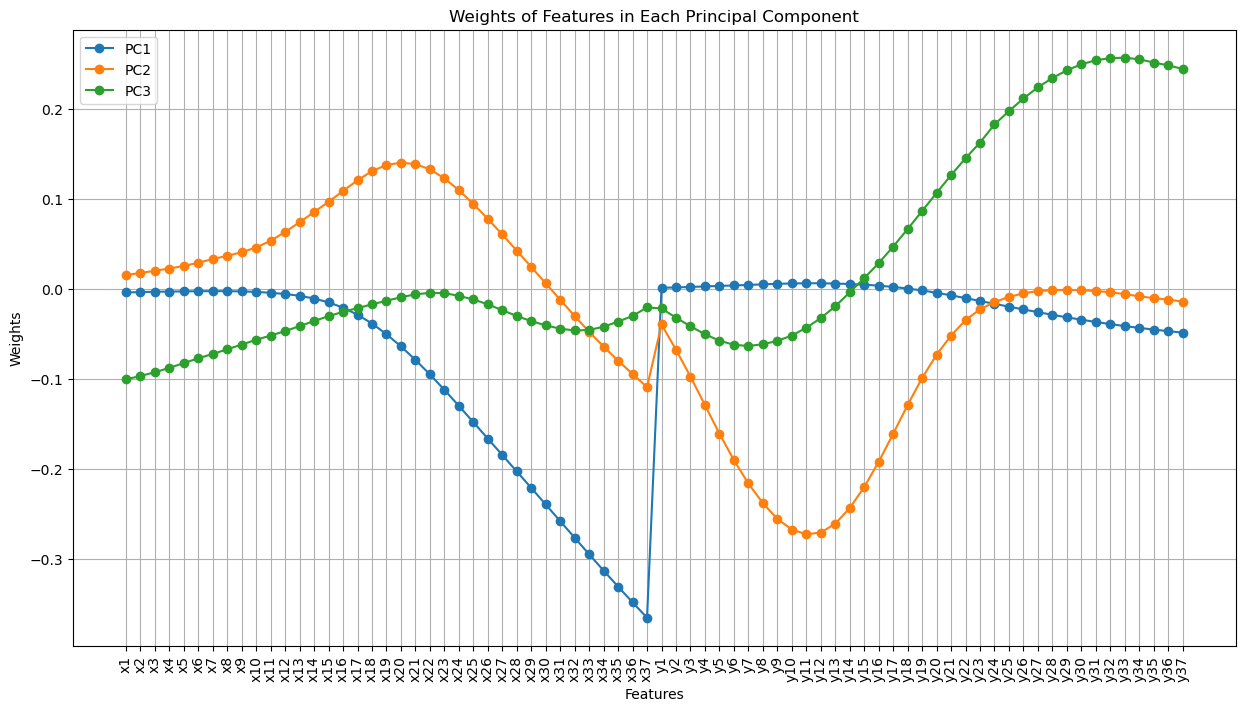

In [21]:
# Define the trajectory columns
pca_columns = [f'x{i}' for i in range(1, 38)] + [f'y{i}' for i in range(1, 38)]

# Extract the coordinate data
coords_data = result_df[pca_columns]

# Perform PCA
n_components = 3
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(coords_data)

# Create a DataFrame for the principal components
pc_columns = [f'PC{i+1}' for i in range(n_components)]
pc_df = pd.DataFrame(principal_components, columns=pc_columns)

# Add the principal components to the original DataFrame
speed_pca = pd.concat([result_df.reset_index(drop=True), pc_df.reset_index(drop=True)], axis=1)

# Scatter plot of PC1 and PC2 with decisions using Plotly
fig = px.scatter(speed_pca, x='PC1', y='PC2', color='decision',
                 title='Scatter Plot of PC1 and PC2 with Decision Distributions',
                 labels={'PC1': 'PC1', 'PC2': 'PC2'},
                 hover_data=['decision'])
fig.update_traces(marker=dict(size=2))
fig.show()

# Plot the explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, tick_label=pc_columns)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.show()

# Show the formula for each PC
components = pca.components_

# Create formulas for each PC
feature_names = coords_data.columns
pc_formulas = {}
for i in range(n_components):
    formula = " + ".join([f"{components[i, j]:.2f}*{feature_names[j]}" for j in range(len(feature_names))])
    pc_formulas[f'PC{i+1}'] = formula

# Create formulas for each PC
feature_names = coords_data.columns
pc_formulas = {}
for i in range(n_components):
    formula = " + ".join([f"{components[i, j]:.2f}*{feature_names[j]}" for j in range(len(feature_names))])
    pc_formulas[f'PC{i+1}'] = formula

# Create a DataFrame for the weights
weights_df = pd.DataFrame(components.T, index=feature_names, columns=pc_columns)

# Plot the weights for each principal component
plt.figure(figsize=(15, 8))
for pc in pc_columns:
    plt.plot(weights_df.index, weights_df[pc], label=pc, marker='o')

plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('Weights of Features in Each Principal Component')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

of both dim deduction:
reject trials are clearly defferentiated from others.
accept and quit trials are partially merged.

implications from PCA results:
PC1 emphasis on x coord after T-Entry, defferentiating between REJ and others.
PC2 emphasis on y coord after T-Entry, partially defferentiating between ACC and quit.
UMAP probably has the similar idea.

generally, UMAP is spliting the decision better than PCA.

Future implication:
use GMM or other non-circular probabilistic clustering model to give a score for each trial, then look at the effect of this score on the classification of neural activity.

In [22]:
coords_umap.head()

x1          y1          x2          y2          x3          y3  \
0  297.271604  125.932236  297.810956  119.994282  298.240149  113.552809   
1  289.563935  128.447126  290.005645  122.230493  290.581654  115.873554   
2  293.917806  126.046794  293.697025  121.348562  293.512995  116.439108   
3  286.956016  131.687361  288.450812  127.777012  289.553869  123.526205   
4  286.481579  129.104102  288.540240  125.478926  289.323751  121.775837   

           x4          y4          x5          y5  ...  \
0  298.339819  106.815038  298.074981  100.134950  ...   
1  291.508640  109.050360  292.761309  101.645353  ...   
2  293.405168  111.175115  293.394795  105.557408  ...   
3  290.203186  118.759048  290.553729  113.821701  ...   
4  289.905958  117.851038  291.111284  113.488322  ...   

   straight_walking_speed  animal  session  trial  trial_length      UMAP1  \
0              150.649940  RRM028   Day136      1           159   9.914902   
1              229.864156  RRM028   Day136      5            46  11.341184   
2              185.055303  RRM028   Day136      9            46  11.778090   
3              150.978190  RRM028   Day136     13           169  10.165674   
4              164.766663  RRM028   Day136     17            48  11.101030   

      UMAP2     UMAP3     UMAP4     UMAP5  
0  5.509571  7.645788  3.096674  3.008399  
1  6.418807  5.335937  3.458453  2.039082  
2  6.610544  6.066361  3.159237  0.947699  
3  4.676816  9.151586  2.475725  2.298427  
4  5.481472  8.531053  2.523695  1.305056  

[5 rows x 85 columns]

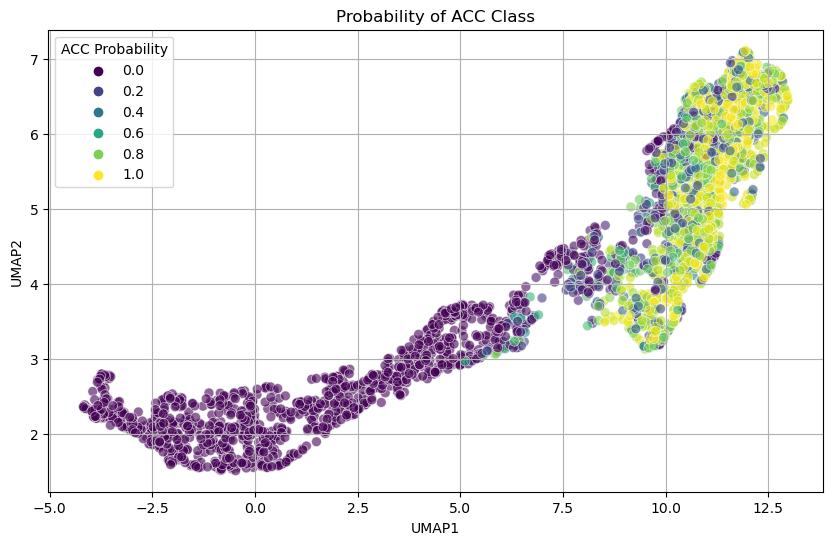

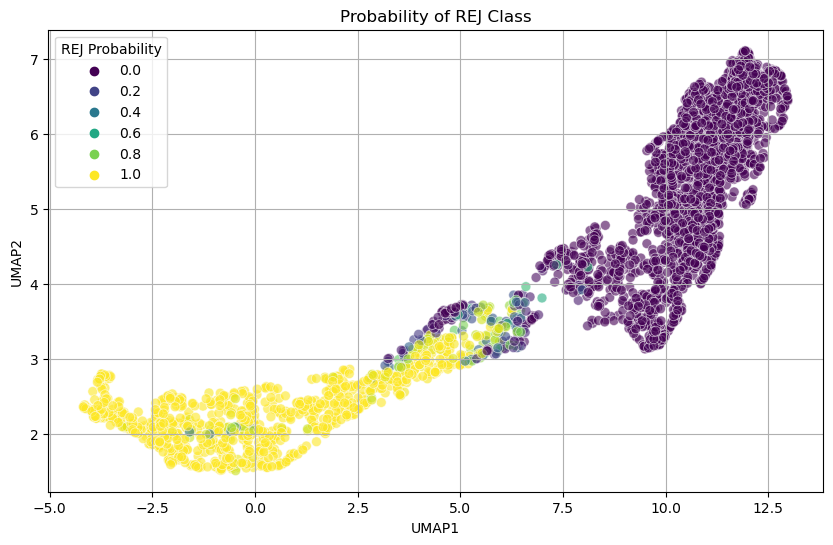

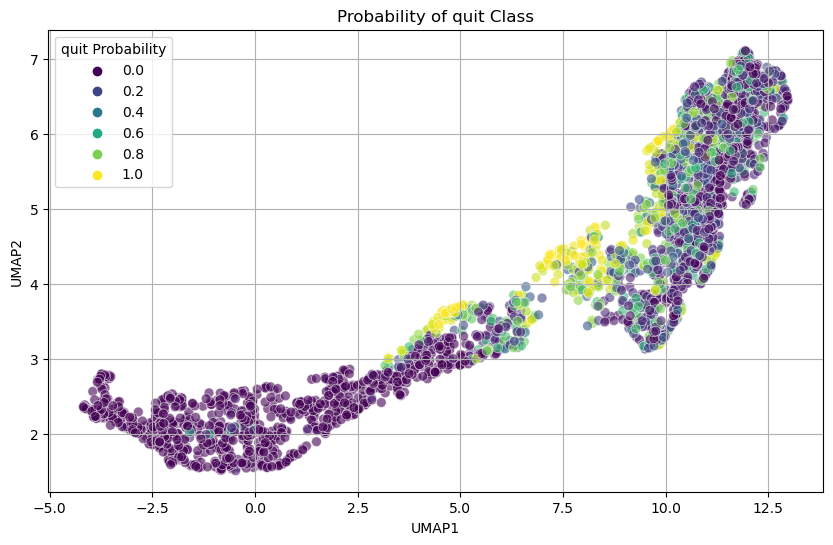

In [23]:
coords_umap_clean = coords_umap.dropna(subset=['UMAP1', 'UMAP2', 'decision'])

desired_decisions = ['ACC', 'REJ', 'quit']
coords_umap_filtered = coords_umap_clean[coords_umap_clean['decision'].isin(desired_decisions)]

X = coords_umap_filtered[['UMAP1', 'UMAP2']]
y = coords_umap_filtered['decision']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

probs = rf.predict_proba(X)
probs_df = pd.DataFrame(probs, columns=[f'{cls}_prob' for cls in rf.classes_])
coords_umap_filtered = pd.concat([coords_umap_filtered.reset_index(drop=True), probs_df], axis=1)

labels = rf.predict(X)
coords_umap_filtered['Predicted'] = labels

# Plot the probabilities for each class
for cls in rf.classes_:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='UMAP1', y='UMAP2', hue=f'{cls}_prob', data=coords_umap_filtered, palette='viridis', s=50, alpha=0.6, edgecolor='w')
    plt.title(f'Probability of {cls} Class')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title=f'{cls} Probability')
    plt.grid(True)
    plt.show()

In [24]:
coords_umap_filtered.describe()

x1           y1           x2           y2           x3  \
count  3896.000000  3896.000000  3896.000000  3896.000000  3896.000000   
mean    287.651801   129.535525   288.184103   124.174887   288.700486   
std       5.697744     2.605057     5.427248     3.310018     5.233421   
min     262.949088   111.023030   262.890320   110.000934   263.154197   
25%     284.423746   128.074701   284.876776   122.146558   285.378084   
50%     288.106215   129.636719   288.546824   124.304985   289.050955   
75%     291.827143   131.098416   292.201125   126.173842   292.500596   
max     302.931891   139.272852   302.808946   137.772092   303.131591   

                y3           x4           y4           x5           y5  ...  \
count  3896.000000  3896.000000  3896.000000  3896.000000  3896.000000  ...   
mean    118.551170   289.219616   112.614443   289.753133   106.366357  ...   
std       4.309626     5.043706     5.387130     4.827832     6.450935  ...   
min      99.356624   264.121610    88.431624   265.711706    76.627359  ...   
25%     116.173181   285.840488   109.463515   286.316006   102.589116  ...   
50%     118.527187   289.599464   112.837781   290.106358   106.783618  ...   
75%     121.380353   292.763149   116.205025   293.092823   110.557882  ...   
max     136.032717   303.830815   134.712418   304.181636   133.398554  ...   

             trial  trial_length        UMAP1        UMAP2        UMAP3  \
count  3896.000000   3896.000000  3896.000000  3896.000000  3896.000000   
mean    116.691478    107.066735     7.810833     4.533974     6.912827   
std      82.210209    362.374171     4.874521     1.644287     1.153765   
min       1.000000     37.000000    -4.180193     1.507507     3.638053   
25%      49.000000     44.000000     4.604847     3.098075     6.245838   
50%     104.000000     48.000000    10.240433     4.722955     6.957287   
75%     171.000000     65.000000    11.305866     6.001742     7.611522   
max     407.000000  12234.000000    12.981378     7.113925     9.479802   

             UMAP4        UMAP5     ACC_prob     REJ_prob    quit_prob  
count  3896.000000  3896.000000  3896.000000  3896.000000  3896.000000  
mean      3.386653     2.819985     0.467921     0.275903     0.256176  
std       0.667161     1.133820     0.416606     0.436709     0.329557  
min       2.311529    -0.006792     0.000000     0.000000     0.000000  
25%       2.876379     1.918202     0.000000     0.000000     0.010000  
50%       3.263156     3.095740     0.340000     0.000000     0.090000  
75%       3.744998     3.824542     0.910000     0.930000     0.600000  
max       5.234343     4.423851     1.000000     1.000000     1.000000  

[8 rows x 85 columns]